# Setup
To setup the environment run the following commands on kaggle

In [1]:
!cp /kaggle/input/a3-2-1/A3_Part2/environment.yml /kaggle/working/
!cp /kaggle/input/a3-2-1/A3_Part2/install.sh /kaggle/working/


!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!



```bash
# Running code for training. save the model in the same directory with name "vae.pth"
# Save the GMM parameters in the same folder. You can use pickle to save the parameters. 
!python vae.py path_to_train_dataset path_to_val_dataset train vae.pth gmm_params.pkl



# Running code for vae reconstruction.
# This should save the reconstruced images in numpy format. see below for more details.
!python vae.py path_to_test_dataset_recon test_reconstruction vae.pth

#Running code for class prediction during testing
!python vae.py path_to_test_dataset test_classifier vae.pth gmm_params.pkl
```
Run your .py file on CLI using the following command

# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import norm

# To be tested

### Data Preparation and Loading
- **Data Loading:**
  - Load images as PyTorch tensors.
  - Implement a custom `Dataset` class for easy data handling.
- **Data Transformation & Preprocessing:**
  - Padding, cropping, and resizing to standardize image dimensions if needed.
  - Apply transforms like grayscale normalization, resizing, and scaling between [0, 1].

### Exploratory Data Analysis (EDA)
- Visualize a few images from each class (1, 4, 8) for reference.
- Calculate the mean and variance of pixel intensities across the dataset.
- Plot pixel intensity histograms and class distributions to check for imbalances.

---

### Model Architectures & Variants
- **Encoder-Decoder Architectures to Try:**
  - **Dense Layers Only**: Simple MLP-based VAE for both encoder and decoder.
  - **CNN-Based Encoder, Dense Decoder**: CNN layers in the encoder to capture spatial patterns, with dense layers for the decoder.
  - **Hybrid Models**: Experiment with CNN-based encoder and decoder for richer representation.
  - **Residual and Skip Connections**: Add residual connections in the encoder to improve information flow.
  
- **Scaling & Regularization Techniques:**
  - Batch Normalization and Layer Normalization
  - Experiment with Dropout, DropBlock
  - Learning rate schedules: `OneCycleLR`, `CyclicLR`, or Learning Rate Warm-Up
  
- **Hyperparameter Tuning:**
  - Adjust KL divergence weight (`β`) to balance reconstruction and regularization.
  - Try different activation functions in hidden layers (`ReLU`, `Leaky ReLU`, etc.)
  - Tune the latent space dimension size (try 2, 3, and 5 dimensions)

---

### Training Strategies
- **Training the VAE:**
  - Focus on reconstruction first, evaluating if the VAE captures essential features.
  - Set up and test different learning rate schedulers for stable training.
  - Monitor loss curves (reconstruction and KL divergence separately) using TensorBoard.

- **Generating Images & Latent Space Evaluation:**
  - Sample from the 2D latent space grid to generate new digits and inspect their quality.
  - Plot the latent space embeddings of the test/validation set for digit clustering.

---

### Gaussian Mixture Model (GMM) on Latent Space
- **GMM Training:**
  - Use validation data to initialize GMM cluster means.
  - Manually implement the GMM training loop to ensure it’s optimized for classification.
  - Plot GMM cluster ellipses over the latent space embeddings.

- **Classification Techniques & Evaluation:**
  - Use Maximum Likelihood estimation to classify new data with the trained GMM.
  - Calculate accuracy, precision, recall, and F1 score on the validation dataset.

---

### Evaluation & Visualization Techniques
- **Reconstruction Evaluation:**
  - Compare reconstruction quality using MSE and SSIM (Structural Similarity Index).
  - Save the reconstructed images for comparison with the original ones.

- **Debugging and Insights:**
  - Use Grad-CAM to understand activations if using CNN layers.
  - Experiment with tools like TensorBoard or Weights & Biases to log training details.
  
- **Calibration Techniques:**
  - Try model calibration techniques to improve class separation if needed.
  - Experiment with temperature scaling
  adjust probability es
timates.

---

### Advanced Options (Optional)
- **Data Augmentation:**
  - Implement slight augmentations, like Exbrightness/contrast jittering, to create vaiotions in the trainng set.
  - Explore Albumentations for adaptive augmentation if you need sample.
  
- **A dressing Imbalances (if applicable):**
  - Use oversamplin for minority classes or implement focal loss for better handling of imbalances.


# DataLoader
Loading the npz files from the dataset

In [3]:
train_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_train.npz')
val_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_val_recon.npz')

## Custom Dataset class
Custom dataset class implemented to load the data during training and testing

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.labels = torch.tensor(labels, dtype=torch.long) # Convert to PyTorch tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

Setting up the dataset and dataloader to check the max value with which the images will be scaled, thus scaling the pixels to [0,1] range

In [5]:
# dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'])
# loader = DataLoader(dataset, batch_size=64, shuffle=True)

# idx = 5
# for image, _ in loader:
#     print(image.max())
#     idx += 1
#     if (idx > 5):
#         break

In [6]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
    transforms.Lambda(lambda x: x.unsqueeze(0) if x.ndim == 2 else x),
    transforms.Normalize(
        mean = (0,), 
        std = (255,)
    )
])

In [7]:
train_dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(data = val_set['data'], labels = val_set['labels'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Basic Implementation

### Log

#### 1) Basic Dense NN Implementation ( 1m params )

- Reconstruction Loss => Train: 142 Val: 137
- GMM Accuracy => 0.13333333333333333
- GMM Precision 'macro' => 0.13333333333333333
- GMM Recall 'macro' => 0.044444444444444
- GMM F1 score 'macro' => 0.066666666666666667

#### 2) Dense NN Implementation ( 1.15m params )

- Reconstruction Loss => Train: 142 Val: 137
- GMM Accuracy => 0.3333333333333333
- GMM Precision 'macro' => 0.1
- GMM Recall 'macro' => 0.11111111111111112
- GMM F1 score 'macro' => 0.1052631578947368484

#### 3) Dense NN Implementation ( 9.45m params )

- Reconstruction Loss => Train: 143 Val: 136
- GMM Accuracy => 0.6
- GMM Precision 'macro' => 0.6428571428571429
- GMM Recall 'macro' => 0.7037037037037037
- GMM F1 score 'macro' => 0.595604395604395656

#### 4) Conv VAE Implementation ( 100k params )

- Reconstruction Loss => Train: 109 Val: 111
- GMM Accuracy => 0.8
- GMM Precision 'macro' => 0.749859142957949
- GMM Recall 'macro' => 0.8037837038038087
- GMM F1 score 'macro' => 0.795704795704379656

#### 5) Conv VAE Implementation ( 200k params )

- Reconstruction Loss => Train: 109 Val: 111
- GMM Accuracy => 1
- GMM Precision 'macro' => 1
- GMM Recall 'macro' => 1
- GMM F1 score 'macro' => 1



In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x[:, :, :self.dim, :self.dim]

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 28, 28)
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.1),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 14, 14)
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.1),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 7, 7)
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.1),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # Output: (64, 7, 7)
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.1)

            nn.Flatten(),
        )

        self.z_mean = nn.Linear(64 * 7 * 7, latent_dim)
        self.z_log_var = nn.Linear(64 * 7 * 7, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            Reshape(-1, 64, 7, 7),
            
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), # Output: (64, 7, 7)
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 7, 7)
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0), # Output: (32, 14, 14)
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),  # Output: (1, 28, 28)
            
            Trim(28),
            nn.Sigmoid()
        )

    def encode(self, x):
        # Pass through convolutional encoder
        x = self.encoder(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std).to(z_mean.get_device())
        return z_mean + eps * std

    def decode(self, z):
        # Pass through fully connected layers and reshape
        x = self.decoder(z)
        return x

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decode(z)
        return decoded, z_mean, z_log_var

In [9]:
def loss_fn(recon_x, x, mu, logvar, beta=1):
    recon_loss = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon_loss + (beta*kl_loss)
    elbo = -(recon_loss + kl_loss)
    
    return total_loss, elbo.item(), recon_loss.item(), kl_loss.item()

In [10]:
import torch
import matplotlib.pyplot as plt

def train(epoch, optimizer, metrics_dict):
    vae.train()
    train_loss = 0
    elbo_loss = 0
    recon = 0
    kl = 0
    
    for batch_idx, (data, *_) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss, elbo, recon_loss, kl_loss = loss_fn(recon_batch, data, mu, log_var, beta = 2)
        loss.backward()
        
        # Detach from computation graph and move to CPU
        train_loss += loss.detach().cpu().item()
        elbo_loss += elbo
        recon += recon_loss
        kl += kl_loss
        
        optimizer.step()
        
    avg_loss = train_loss / len(train_loader.dataset)
    avg_elbo = elbo_loss / len(train_loader.dataset)
    avg_recon = recon / len(train_loader.dataset)
    avg_kl = kl / len(train_loader.dataset)
    
    # Store metrics
    metrics_dict['train_loss'].append(avg_loss)
    metrics_dict['train_elbo'].append(avg_elbo)
    metrics_dict['train_recon'].append(avg_recon)
    metrics_dict['train_kl'].append(avg_kl)
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    
    return avg_loss, avg_elbo, avg_recon, avg_kl

def test(metrics_dict):
    vae.eval()
    test_loss = 0
    elbo_loss = 0
    recon = 0
    kl = 0
    
    with torch.no_grad():
        for data, *_ in test_loader:
            data = data.to(device)
            
            recon_out, mu, log_var = vae(data)
            loss, elbo, recon_loss, kl_loss = loss_fn(recon_out, data, mu, log_var)
            
            # Move to CPU
            test_loss += loss.detach().cpu().item()
            elbo_loss += elbo
            recon += recon_loss
            kl += kl_loss
    
    avg_loss = test_loss / len(test_loader.dataset)
    avg_elbo = elbo_loss / len(test_loader.dataset)
    avg_recon = recon / len(test_loader.dataset)
    avg_kl = kl / len(test_loader.dataset)
    
    # Store metrics
    metrics_dict['test_loss'].append(avg_loss)
    metrics_dict['test_elbo'].append(avg_elbo)
    metrics_dict['test_recon'].append(avg_recon)
    metrics_dict['test_kl'].append(avg_kl)
    
    print(f'====> Test set loss: {avg_loss:.4f}')
    return avg_loss, avg_elbo, avg_recon, avg_kl

def plot_metrics(metrics_dict):
    """Plot training and testing metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('VAE Training Metrics')
    
    # Plot total loss
    axes[0, 0].plot(metrics_dict['train_loss'], label='Train')
    axes[0, 0].plot(metrics_dict['test_loss'], label='Test')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    
    # Plot ELBO
    axes[0, 1].plot(metrics_dict['train_elbo'], label='Train')
    axes[0, 1].plot(metrics_dict['test_elbo'], label='Test')
    axes[0, 1].set_title('ELBO')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    
    # Plot Reconstruction Loss
    axes[1, 0].plot(metrics_dict['train_recon'], label='Train')
    axes[1, 0].plot(metrics_dict['test_recon'], label='Test')
    axes[1, 0].set_title('Reconstruction Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    
    # Plot KL Divergence
    axes[1, 1].plot(metrics_dict['train_kl'], label='Train')
    axes[1, 1].plot(metrics_dict['test_kl'], label='Test')
    axes[1, 1].set_title('KL Divergence')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)
print(f"No. of model parameters: {sum(p.numel() for p in vae.parameters() if p.requires_grad)}")

No. of model parameters: 207237


In [12]:
# Usage example:
metrics_dict = {
    'train_loss': [], 'train_elbo': [], 'train_recon': [], 'train_kl': [],
    'test_loss': [], 'test_elbo': [], 'test_recon': [], 'test_kl': []
}

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=7e-4)

# Define the scheduler (reduce LR by a factor of 0.5 every 10 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train(epoch, optimizer, metrics_dict)
    test(metrics_dict)

    scheduler.step()

====> Epoch: 0 Average loss: 195.7704
====> Test set loss: 129.1296
====> Epoch: 1 Average loss: 133.0074
====> Test set loss: 124.1388
====> Epoch: 2 Average loss: 128.3308
====> Test set loss: 120.0805
====> Epoch: 3 Average loss: 126.0502
====> Test set loss: 120.7539
====> Epoch: 4 Average loss: 124.4121
====> Test set loss: 120.0869
====> Epoch: 5 Average loss: 123.3776
====> Test set loss: 117.5273
====> Epoch: 6 Average loss: 122.6925
====> Test set loss: 118.9507
====> Epoch: 7 Average loss: 122.1607
====> Test set loss: 116.5991
====> Epoch: 8 Average loss: 121.5698
====> Test set loss: 117.4729
====> Epoch: 9 Average loss: 121.1915
====> Test set loss: 118.8028
====> Epoch: 10 Average loss: 120.1585
====> Test set loss: 115.6494
====> Epoch: 11 Average loss: 119.9601
====> Test set loss: 116.1625
====> Epoch: 12 Average loss: 119.8031
====> Test set loss: 114.9522
====> Epoch: 13 Average loss: 119.5920
====> Test set loss: 117.8548
====> Epoch: 14 Average loss: 119.4757
====>

## Train and Test loss for reconstructed images

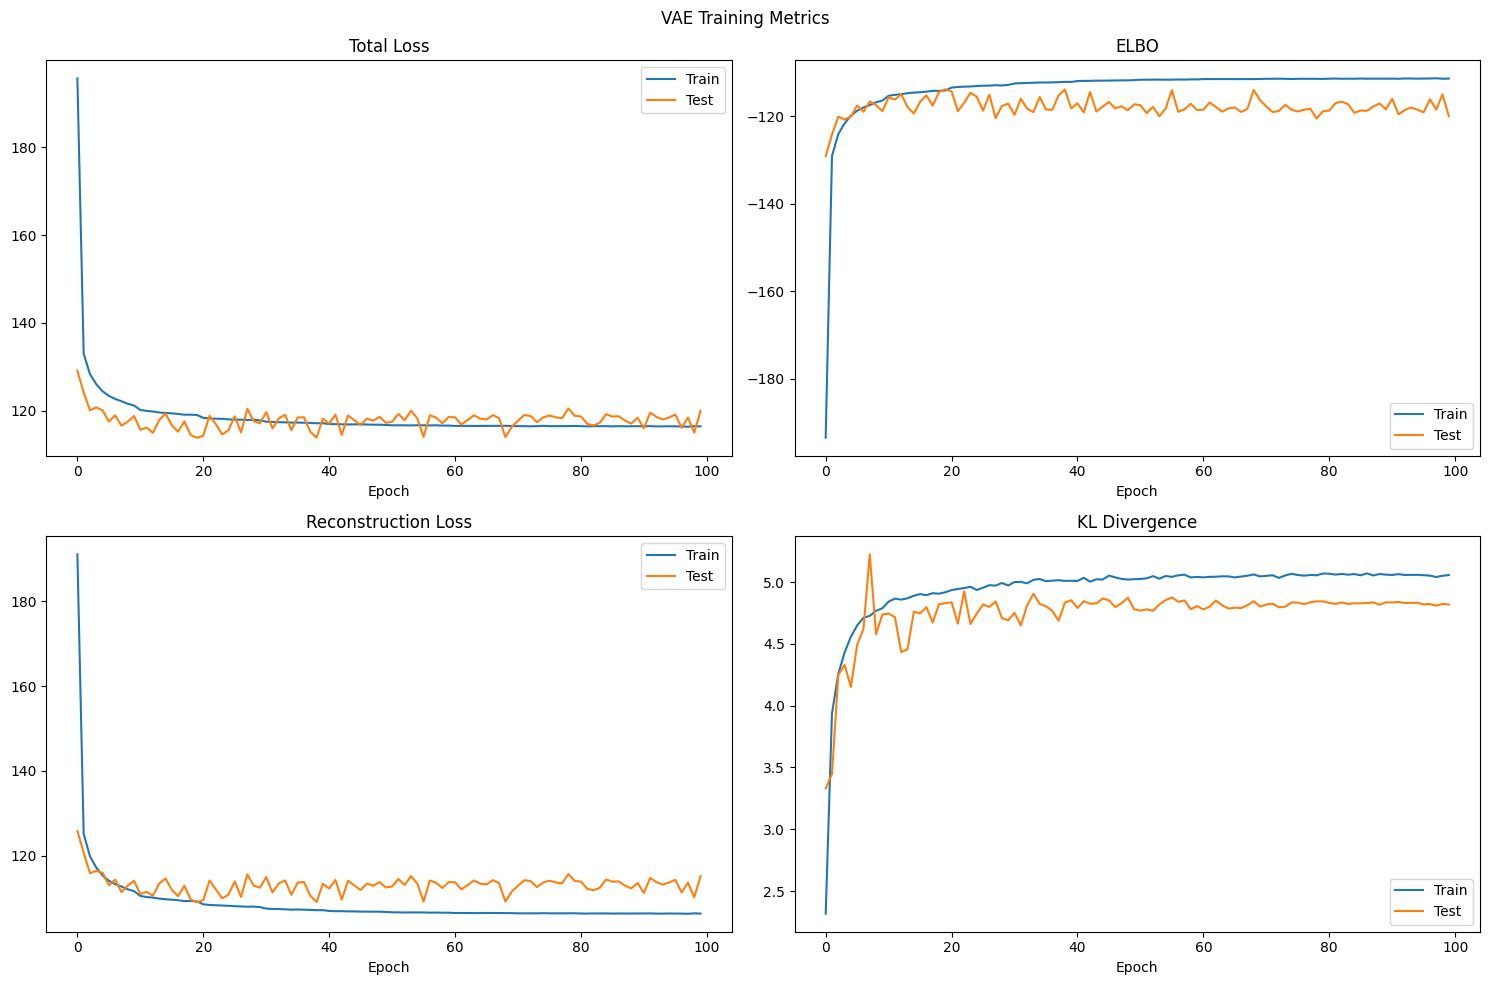

In [13]:
# Plot results
plot_metrics(metrics_dict)

## Reconstructing image

The reconstruction ability of your implementation will be evaluated. For images in the validation dataset, plot the reconstructed image from VAE and **add in the report**. 

For consistency, use the following code to visualize the reconstructed images.

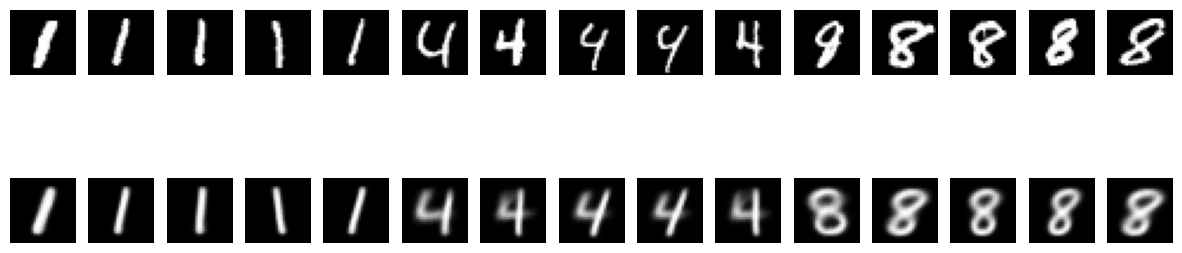

In [14]:
def show_reconstruction(model, val_loader, n=10):
    model.eval()
    data, labels = next(iter(val_loader))

    data = data.to(device)
    recon_data, _, _ = model(data) # Needs to be changed
    
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    for i in range(n):
        # Original images
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(recon_data[i].cpu().view(28, 28).detach().numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

n = 15
val_loader = DataLoader(test_dataset, batch_size = n)
show_reconstruction(vae, val_loader, n=n)

## Similarity Score
We will evaluate the reconstructed images with a combination of (1 - Mean square error) between predicted and ground truth images and structural similarity score (SSIM). Ensure that you image output  range is between 0-1. 

In [15]:
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn.functional as F

def similarity_scores(model, val_loader, n=10):
    model.eval()
    data, labels = next(iter(val_loader))

    # Send data to the device
    data = data.to(device)
    
    # Generate reconstructions with the model
    with torch.no_grad():
        recon_data, _, _ = model(data)  # Adjust indices if model output differs

    # Initialize lists to store SSIM and (1 - MSE) scores
    ssim_scores = []
    mse_scores = []

    # Compute SSIM and (1 - MSE) scores for each image in the batch
    for i in range(n):
        # Move images to CPU and convert to numpy for SSIM calculation
        original_img = data[i].cpu().numpy().squeeze()
        reconstructed_img = recon_data[i].cpu().numpy().squeeze()
        
        # SSIM calculation
        ssim_score = ssim(original_img, reconstructed_img, data_range=1.0)
        ssim_scores.append(ssim_score)
        
        # MSE and (1 - MSE) calculation
        mse = F.mse_loss(data[i], recon_data[i]).item()
        mse_score = 1 - mse  # Inverted MSE similarity score
        mse_scores.append(mse_score)

    # Calculate mean SSIM and (1 - MSE) scores for the batch
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse_score = sum(mse_scores) / len(mse_scores)

    print(f"Average SSIM Score: {avg_ssim:.4f}")
    print(f"Average 1 - MSE Score: {avg_mse_score:.4f}")

    return avg_ssim, avg_mse_score

In [16]:
# Example usage with val_loader and VAE model
n = 15
val_loader = DataLoader(train_dataset, batch_size=n)
similarity_scores(vae, val_loader, n=n)

Average SSIM Score: 0.7401
Average 1 - MSE Score: 0.9781


(0.7401428578956715, 0.9781174616577725)

In [17]:
n = 15
val_loader = DataLoader(test_dataset, batch_size=n)
similarity_scores(vae, val_loader, n=n)

Average SSIM Score: 0.6491
Average 1 - MSE Score: 0.9694


(0.6490700839556853, 0.969424992458274)

## Generating New Images

Note that the latent space of the VAE is normal distribution that allows us to sample latent vectors and pass it to the decoder to generate new images from the data distribution. In this part of the assignment, we will evaluate the VAE's generation capability by uniformly sampling from the latent space. Specifically, use the following code snippet to sample latent vectors, feed them into the VAE’s decoder, and generate new images. **Include these generated images in your report** to show your VAE's generative performance.

You can use the following code to generated images and plot in form of grid..

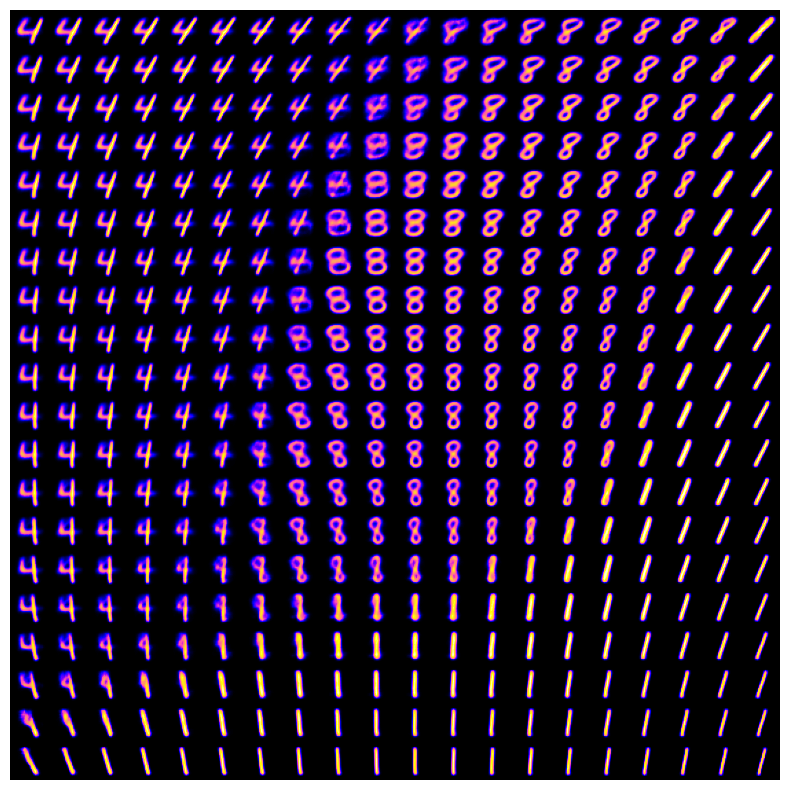

In [18]:
def plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device='cuda'):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Generate a grid of values between 0.05 and 0.95 percentiles of a normal distribution
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    vae.eval()  # Set VAE to evaluation mode
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = torch.tensor([[xi, yi]], device=device).float()

                # Pass z to VAE Decoder
                digit = vae.decode(z_sample)
                # Write your code here
                digit = digit.view(digit_size, digit_size).cpu().numpy()

                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit


    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.axis('off')
    plt.show()

plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device=device)

## Visualizing Latent Space

To visualize the structure of the VAE's latent space, extract the latent vector for each image in the training dataset, then plot these vectors in a 2D scatter plot. Add this scatter plot to your report and observe the distribution. Look for distinct clustering patterns—ideally, you should see three clusters, each resembling a 2D normal distribution. Comment on whether the clusters are well-separated and follow the expected distribution, indicating the VAE has effectively organized the latent space for classification.

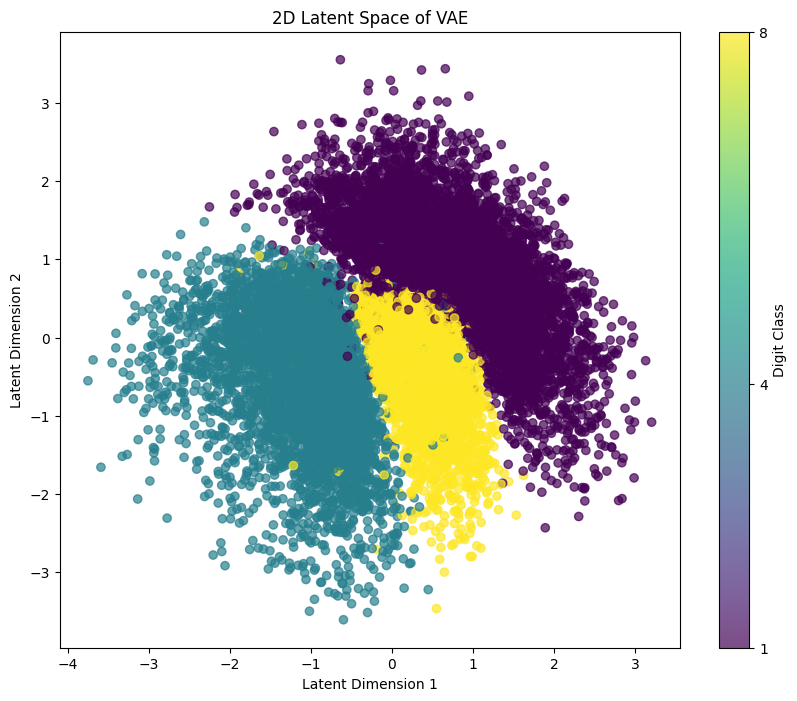

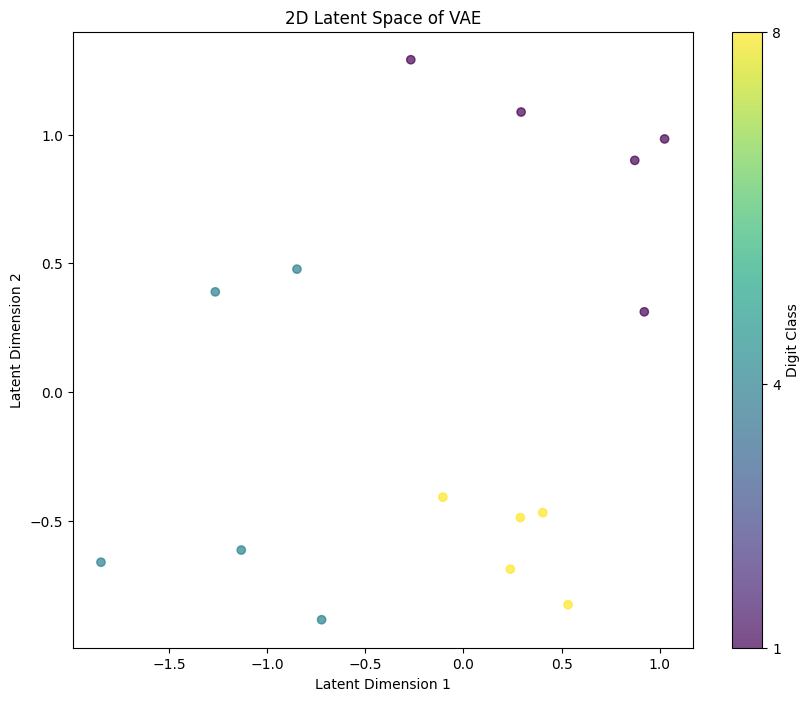

In [19]:
def visualize_latent_space(vae, dataloader, device='cuda'):
    vae.eval()  # Set VAE to evaluation mode
    
    all_latents = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            
            # Encode data to obtain latent mean (mu) and log variance (log_var)
            mu, log_var = vae.encode(data)
            
            # Sample latent vector z from the distribution (using reparameterization trick)
            z = vae.reparameterize(mu, log_var)
            
            # Append to lists
            all_latents.append(z.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all collected latent vectors and labels
    all_latents = torch.cat(all_latents).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Plot the 2D latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    
    colorbar = plt.colorbar(scatter, ticks=[1, 4, 8])
    colorbar.set_label('Digit Class')
    colorbar.set_ticklabels(['1','4','8'])
    
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("2D Latent Space of VAE")
    plt.show()

# Example usage with DataLoader, assuming you have a DataLoader named 'train_loader'
visualize_latent_space(vae, train_loader, device=device)
visualize_latent_space(vae, test_loader, device=device)

# Implementing the GMM

In [20]:
class GMM:
    """
    A Gaussian Mixture Model (GMM) implementation for clustering data, 
    using Expectation-Maximization (EM).
    """
    def __init__(self, n_components, max_iter=1000, tol=None):
        """
        Initialize the model parameters.
        Paramters:
            n_components (int): The number of clusters (Gaussian components).
            max_iter (int, optional): Maximum number of iterations for EM algorithm. Defaults to 1000.
            tol (float, optional): Convergence threshold for log-likelihood improvement. Defaults to None.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None # Mixing coefficients (weights of each Gaussian)

    def _initialize_parameters(self, X):
        """
        Initialize means, covariances, and mixing weights.
        Parameters:
            X (ndarray): Input data with shape (n_samples, n_features).
        """
        n_samples, n_features = X.shape
        np.random.seed(0)

        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = self.means if self.means is not None else X[indices]

        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]

        self.weights = np.full(self.n_components, 1 / self.n_components)

    def _regularize_covariance(self, cov_matrix, epsilon=1e-6):
        """
        Add a small constant to the diagonal to prevent singularity.
        Parameters:
            cov_matrix (ndarray): covariance matrix
            epsilon (float): small value to be added, to make cov matrix stable. Defaults to 1e-6.

        Returns:
            ndarray: regularized cov matrix
        """
        return cov_matrix + np.eye(cov_matrix.shape[0]) * epsilon

    def _safe_exponent(self, exponent, max_val=1e10):
        """
        Clipping exponent value for neumerical stability.
        Parameters:
            exponent (ndarray): exponentiated cov matrix.

        Returns:
            ndarray: Clipped exponentiated cov matrix.
        """
        return np.clip(exponent, -max_val, max_val)        
    
    def _compute_multivariate_gaussian(self, X, mean, covariance):
        """
        Compute multivariate Gaussian probability for each sample in X.
        Parameters:
            X (ndarray): Data points, shape (n_samples, n_features).
            mean (ndarray): Mean vector of a Gaussian component, shape (n_features,).
            covariance (ndarray): Covariance matrix of a Gaussian component, shape (n_features, n_features).

        Returns:
            ndarray: Gaussian probabilities, shape (n_samples,).
        """
        X = X.reshape(X.shape[0], -1)
        n, n_features = X.shape
        
        # Regularize the covariance matrix to avoid singularity
        cov = self._regularize_covariance(covariance)
        
        try:
            # Compute the determinant and inverse of the covariance matrix
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)
    
            # Avoid invalid determinant values
            if det_cov <= 0:
                raise ValueError("Covariance matrix is singular.")
            
            # Compute the normalization factor
            norm_factor = 1.0 / (np.sqrt((2* np.pi) ** n_features * det_cov))
            
            # Calculate exponent safely
            diff = X - mean
            exponent_term = -0.5 * np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
            
            return norm_factor * np.exp(exponent_term)
        
        except np.linalg.LinAlgError:
            print("Error: Covariance matrix is not invertible.")
            return  np.full(X.shape[0], np.nan)  # Assign NaN to indicate failure in computation

    def _expectation_step(self, X):
        """
        E-step: Calculate responsibility matrix.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).

        Returns:
            ndarray: Responsibility matrix, shape (n_samples, n_components).
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            MVG = self._compute_multivariate_gaussian(X, self.means[k], self.covariances[k])
            responsibilities[:, k] = self.weights[k] * MVG

        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum

        return responsibilities

    def _maximization_step(self, X, responsibilities):
        """
        M-step: Update model parameters based on responsibilities.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).
            responsibilities (ndarray): Responsibility matrix.
        """
        n_samples, n_features = X.shape

        for k in range(self.n_components):
            N_k = responsibilities[:, k].sum()

            # Update means
            self.means[k] = (1 / N_k) * np.sum(responsibilities[:, k, None] * X, axis=0)

            # Update covariances
            diff = X - self.means[k]
            cov_k = (responsibilities[:, k, None] * diff).T @ diff / N_k
            self.covariances[k] = self._regularize_covariance(cov_k)

            # Update weights
            self.weights[k] = N_k / n_samples

    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data given the current model parameters.
        Parameters:
            X (ndarray): Input data, shape (n_samples, n_features).

        Returns:
            float: Log-likelihood of the data
        """
        log_likelihood = 0
        for k in range(self.n_components):
            MVG = self._compute_multivariate_gaussian(X, self.means[k], self.covariances[k])
            log_likelihood += self.weights[k] * MVG

        return np.sum(np.log(log_likelihood + 1e-10))

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm
        Parameters:
            X (ndarray): Training data, shape (n_samples, n_features).
        """
        self._initialize_parameters(X)

        log_likelihood_prev = None
        for i in range(self.max_iter):
            responsibilities = self._expectation_step(X)
            self._maximization_step(X, responsibilities)

            log_likelihood = self._compute_log_likelihood(X)
            if log_likelihood_prev is not None and self.tol is not None and abs(log_likelihood - log_likelihood_prev) < self.tol:
                print(f'Converged in {i} iterations.')
                break
            log_likelihood_prev = log_likelihood

    def predict(self, X):
        """
        Assign each sample to the Gaussian component with the highest responsibility.
        Parameters:
            X (ndarray): Data to predict, shape (n_samples, n_features).

        Returns:
            list: Component labels for each sample.
        """
        responsibilities = self._expectation_step(X)
        return responsibilities.argmax(axis=1)

    def predict_proba(self, X):
        """
        Calculate the probability of each sample for each component.
        Parameters:
            X (ndarray): Data to predict, shape (n_samples, n_features).

        Returns:
            ndarray: Probability matrix, shape (n_samples, n_components).
        """
        return self._expectation_step(X)

In [21]:
# Step 1: Calculate Class-Specific Means and Assign GMM Clusters
def initialize_gmm_means(vae, val_loader, device='cpu'):
    """
    Calculate class-specific means in the latent space and directly set these as initial GMM cluster centers.

    :param vae: Trained VAE model (torch.nn.Module).
    :param val_loader: DataLoader - Validation data loader with images and labels.
    :param device: str - Device ('cpu' or 'cuda').
    :return: tuple - (initial_means, class_labels), where initial_means is the array of class-specific means 
             and class_labels contains the actual labels for each mean.
    """
    vae.eval()
    class_latent_vectors = {}

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            
            # Encode and extract mean latent vectors
            means = vae.encode(images)[0].cpu().numpy()
            labels = labels.cpu().numpy()

            # Aggregate latent vectors by class label
            for mean, label in zip(means, labels):
                if label not in class_latent_vectors:
                    class_latent_vectors[label] = []
                class_latent_vectors[label].append(mean)

    # Calculate mean vector for each class and store labels
    class_means = [np.mean(latent_vectors, axis=0) for latent_vectors in class_latent_vectors.values()]
    class_labels = list(class_latent_vectors.keys())
    
    return np.array(class_means), class_labels

# Step 2: Train the GMM with Class-Specific Initial Means
def train_gmm_with_class_means(gmm, vae, train_loader, init_means, device='cpu'):
    """
    Train the GMM on latent vectors with initial means set to class-specific means.
    
    :param gmm: GMM instance.
    :param vae: Trained VAE model (torch.nn.Module).
    :param train_loader: DataLoader - Training data loader with images.
    :param init_means: ndarray - Initial class-specific mean vectors to set GMM centers.
    :param device: str - Device ('cpu' or 'cuda')
    """
    vae.eval()
    
    # Set initial means in GMM directly as calculated from classes
    gmm.means = init_means
    
    # Extract latent vectors from training data
    latent_vectors = []
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            mean = vae.encode(images)[0].cpu().numpy()
            latent_vectors.append(mean)

    # Concatenate all latent vectors from mini-batches
    latent_vectors = np.vstack(latent_vectors)
    
    # Fit GMM to latent vectors
    gmm.fit(latent_vectors)

# Step 3: Classify New Images with GMM Clusters Directly Mapped to Class Labels
def classify_images(vae, gmm, test_loader, class_labels, device='cpu'):
    """
    Classify images by encoding them with the VAE, using the trained GMM, 
    and mapping clusters to actual class labels directly.
    
    :param vae: Trained VAE model.
    :param gmm: Trained GMM model.
    :param test_loader: DataLoader - Test data loader with images.
    :param class_labels: list - List of actual class labels in the order of GMM clusters.
    :param device: str - Device ('cpu' or 'cuda').
    :return: list - Predicted class labels for each sample.
    """
    vae.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            mean = vae.encode(images)[0].cpu().numpy()

            # Predict cluster numbers using GMM and map directly to class labels
            clusters = gmm.predict(mean)
            batch_predictions = [class_labels[cluster] for cluster in clusters]
            predictions.extend(batch_predictions)
    
    return predictions

In [22]:
gmm_dataset = CustomDataset(data = val_set['data'], labels = val_set['labels'], transform=transform)
gmm_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [37]:
# Using the optimized functions
# Compute initial means for GMM and corresponding class labels using the validation dataset
initial_means, class_labels = initialize_gmm_means(vae, gmm_loader, device)

# Initialize and train GMM
gmm = GMM(n_components=len(class_labels), max_iter=100, tol=1e-10)
train_gmm_with_class_means(gmm, vae, gmm_loader, initial_means, device)

# Classify new test images with the trained GMM
predictions = classify_images(vae, gmm, test_loader, class_labels, device)

Converged in 15 iterations.


## Visualize the means

In [38]:
# plt.scatter(x = initial_means[:,0], y = initial_means[:,1])

## Visualizing GMM

To visualise the GMM model, plot each Gaussian distribution as an ellipse, with the center representing the mean and the shape reflecting the covariance. This visualisation will help assess whether the learned GMM effectively separates the clusters. Analyze the plot to determine if the clusters are distinct or if there is overlap that could indicate misclassification.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch

def plot_gmm_ellipses(gmm, X, labels=None):
    """
    Plot the GMM clusters as ellipses with means and covariances visualized.
    
    :param gmm: Trained GMM model with means, covariances, and weights.
    :param X: ndarray - Data points in the latent space (n_samples, 2).
    :param labels: list or array, optional - Predicted labels for each sample.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot data points, colored by cluster labels if provided
    if labels is not None:
        for label in np.unique(labels):
            ax.scatter(X[labels == label, 0], X[labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.6)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.6)

    # Plot each Gaussian component as an ellipse
    for i in range(gmm.n_components):
        mean = gmm.means[i]
        covariance = gmm.covariances[i]

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariance)
        
        # Determine angle of ellipse based on eigenvectors
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        
        # Scale eigenvalues to determine ellipse width and height
        width, height = 2 * np.sqrt(eigvals)
        
        # Create and plot the ellipse
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='red', facecolor='none', lw=2)
        ax.add_patch(ellipse)
        
        # Plot mean center of each Gaussian component
        ax.scatter(*mean, color='red', s=100, marker='x')  # Center of the Gaussian component

    ax.set_title("GMM Clusters in Latent Space with Ellipses")
    ax.legend()
    plt.show()

# Step 1: Extract latent space representations from the VAE encoder
def get_latent_space(loader, vae, device='cpu'):
    """
    Obtain the latent space representations of the data from the VAE encoder.
    
    :param loader: DataLoader - Data loader with images and labels.
    :param vae: Trained VAE model.
    :param device: str - Device ('cpu' or 'cuda').
    :return: tuple - (latent_vectors, labels) in latent space.
    """
    latent_vectors = []
    labels = []
    vae.eval()
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)  # Send data to device
            mu, _ = vae.encode(data)  # Get mean representation from encoder
            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.numpy())
    
    return np.concatenate(latent_vectors), np.concatenate(labels)

# Step 2: Prepare and visualize latent space with GMM
def visualize_gmm_clusters(vae, gmm, loader, device='cpu'):
    """
    Visualize clusters of a GMM model in the VAE latent space.
    
    :param vae: Trained VAE model.
    :param gmm: Trained GMM model.
    :param loader: DataLoader - Data loader with images and labels.
    :param device: str - Device ('cpu' or 'cuda').
    """
    # Step 1: Get latent space representations and true labels
    latent_vectors, true_labels = get_latent_space(loader, vae, device)
    
    # Step 2: Predict GMM clusters for latent vectors
    predicted_clusters = gmm.predict(latent_vectors)
    
    # Step 3: Plot the GMM clusters with ellipses
    plot_gmm_ellipses(gmm, latent_vectors, labels=predicted_clusters)

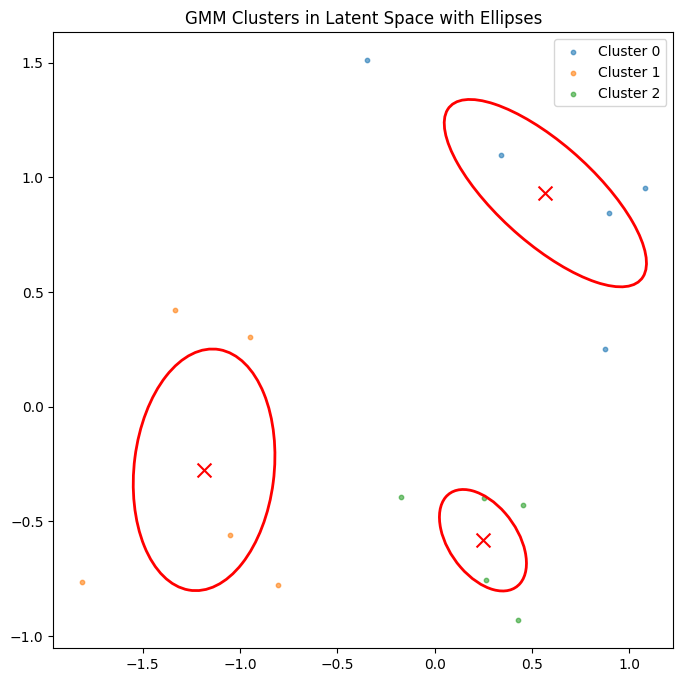

In [40]:
# Ensure your models are loaded and set to evaluation mode
vae = vae.to(device)  # Move VAE model to the specified device
vae.eval()            # Set VAE to evaluation mode

# Assume gmm is your pre-trained GMM model and loader is your data loader
# visualize_latent_space(vae, gmm_loader, device=device)
visualize_gmm_clusters(vae, gmm, gmm_loader, device=device)

## Evaluating GMM

The following 4 criteria will be used to evaluate the GMM model after the predictions using latent space vectors from the previously trained Varitational-Autoencoder

In [41]:
def evaluate_gmm_performance(labels_true, labels_pred):
    """
    Evaluate the performance of a GMM using common classification metrics.
    
    :param labels_true: The true labels (ground truth) for the data.
    :param labels_pred: The predicted labels from the GMM.

    :return: A dictionary with accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(labels_true, labels_pred)
    precision_macro = precision_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro precision
    recall_macro = recall_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro recall
    f1_macro = f1_score(labels_true, labels_pred, average='macro', zero_division=0)  # Macro F1

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }


In [42]:
labels_val = []
for _, labels in test_loader:
    labels_val.append(labels.item())

In [43]:
# Example usage:
metrics = evaluate_gmm_performance(labels_val, predictions)
metrics

{'accuracy': 1.0, 'precision_macro': 1.0, 'recall_macro': 1.0, 'f1_macro': 1.0}